# Fix Hyperparameters
# Add Linear Scheduler
# Implement Forward Gradients

## Setup & Dataset Import

### Import Modules

In [ ]:
!pip install -U "ray[air]"

In [6]:
from functools import partial
import os
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from matplotlib.pyplot import figure
# from ray import tune
# from ray.air import Checkpoint, session
# from ray.tune.schedulers import ASHAScheduler

### Hyperparameters

In [46]:
batch_size = 128
supervised = True
lrs = [1e-2,3e-4,4e-4,5e-5,3e-4]
momentums = [0.9,0.9,0.9,0.9,0.9]
weight_decays = [1e-5,1e-5,4e-4,3e-4,1e-5]
weight_decay = 1e-3
weight_decay_final = 3e-3
thresholds = [50,1000,1000,1000]
num_epochs = 100
records_per_epoch = 4
seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Read & Load Data

In [28]:
# import MNIST
def load_mnist(data_dir="./data"):
  train_data = datasets.MNIST(
      root = data_dir,
      train = True,
      transform = ToTensor(),
      download = True,
  )
  test_data = datasets.MNIST(
      root = data_dir,
      train = False,
      transform = ToTensor(),
      download = True
  )
  return train_data,test_data

In [29]:
train_data, test_data = load_mnist()

In [30]:
# Dataloader
train_loader = DataLoader(train_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=1)

test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=1)

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x79002b4d03a0>,
 <torch.utils.data.dataloader.DataLoader at 0x79002b4d1cf0>)

## Construct Negative Examples for Unsupervised Training



In [ ]:
filter = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]])

def blur(img,filter):
  # blur img using filter
  # params: filter --> torch.tensor(2*radius+1,2*radius+1)
  m,n = img.shape
  radius = (filter.shape[0]-1)//2
  new_img = torch.zeros(m,n)
  for i in range(m):
    for j in range(n):
      top,left,bottom,right = max(0,i-radius),max(0,j-radius),min(m-1,i+radius),min(m-1,j+radius)
      new_img[i][j] = sum([img[x][y]*filter[x-i+radius][y-j+radius]
                           for y in range(left,right+1) for x in range(top,bottom+1)])
  return new_img

def generate_negative_example():
  # construct a negative example for unsupervised case (3.2 in paper)
  mask = (torch.rand(28,28) > 0.5).long() # initiate as random bit image

  for i in range(6): # repeat blurring 6 times
    mask = blur(mask,filter)

  mask = (mask > 0.5).long() # mask

  index1,index2 = torch.randint(len(train_data),(2,))
  return (mask * train_data[index1][0] + (1-mask) * train_data[index2][0])

## Model Definition



In [31]:
# single-layer NN
class one_layer_net(torch.nn.Module):

    def __init__(self, in_size, out_size):
        super(one_layer_net, self).__init__()

        # hidden layer
        # self.layer = torch.nn.Sequential(
            # torch.nn.Flatten(), # nn.Flatten to standardize input shape
            # torch.nn.Linear(in_size, out_size),
            # torch.nn.ReLU() # activation function
        # )
        self.flatten = nn.Flatten()
        self.layer = nn.Linear(in_size, out_size)
        self.relu = nn.ReLU()

    def forward(self, x):
      f = self.flatten(x)
      l = self.layer(f)
      r = self.relu(l)
      return r

In [32]:
# full network
class net(nn.Module):
    # Constructor
    def __init__(self,in_size):
        super(net, self).__init__()
        self.layer1 = one_layer_net(in_size,2000)
        self.layer2 = one_layer_net(2000,2000)
        self.layer3 = one_layer_net(2000,2000)
        self.layer4 = one_layer_net(2000,2000)
        self.ln = nn.LayerNorm(2000) # layernorm

        # softmax layer for hard negative label generation
        self.out_layer = nn.Linear(6000, 10)

        self.layers = [self.layer1,self.layer2,self.layer3,self.layer4,self.out_layer]

    def forward(self,x):
        # x-->tensor (batch_size,channel,height,width)
        # return res --> tensor (batch_size,10)
        interms = []
        interm = x.detach().clone()

        for index in range(len(self.layers)-1):
          layer = self.layers[index] # linear layer
          output = layer(interm) # run the layer
          interm = self.ln(output) # layer-norm
          interms.append(interm.detach().clone()) # store normalized activity

        final_input = torch.cat(interms[1:],dim=1)
        res = self.out_layer(final_input) # final output layer
        return res

    def predict(self,x,device):
        # x-->tensor (batch_size,channel,height,width)
        # return labels --> tensor (batch_size,1)
        accumulate_goodness = torch.zeros(x.shape[0],10).to(device) # accumulate goodness for each label
        for i in range(10): # iterate through all labels
          interm = x.detach().clone()

          # update one-hot label encoding
          interm[:,:,0,:10] = 0
          interm[:,:,0,i] = 1

          for index in range(len(self.layers)-1):
            layer = self.layers[index]
            interm = layer(interm)

            if index > 0: # accumulate goodness for all activities but first hidden layer
              accumulate_goodness[:,i] = accumulate_goodness[:,i] + self.goodness(interm)

            if index + 1 < len(self.layers): # layernorm
              interm = self.ln(interm)
        return torch.argmax(accumulate_goodness,dim=1)

    def goodness(self,x):
        # goodness functions--sum of squares
        # input: x-->tensor (batch_size, ...) (arbitrary shape that starts with batch_size)
        # return goodness-->tensor (batch_size,1)

        x = x.reshape(x.shape[0],-1)
        return torch.sum(torch.square(x),dim=1)

    def criterion(self,x, threshold):
        # criterion function--mean(sigmoid(goodness - threshold))
        # input: x-->tensor (batch_size, ...) (arbitrary shape that starts with batch_size)
        # return loss-->float

        goodness = self.goodness(x)
        res = torch.mean(torch.sigmoid(goodness - threshold))
        # print(goodness,res)
        return res

    def construct_supervised_example(self,x,y,positive=True):
        # construct positive or negative examples for supervised training
        # x-->tensor (batch_size,channel,height,width)
        # y-->tensor (batch_size,)
        # return ans-->tensor (batch_size,channel,height,width)

        ans = x.detach().clone()

        if positive:
          # one-hot encoding
          ans[:,:,0,:10] = 0
          for i in range(x.shape[0]):
             ans[i,:,0,y[i]] = 1

        else:
          ans[:,:,0,:10] = 0.1 # initialize neutral label

          # run forward pass
          labels = self.forward(ans)

          for i in range(x.shape[0]):
             labels[i][y[i]] = -float('inf') # omit positive label
          prob = torch.softmax(labels,dim=1) # probability distribution to choose label
          negative_label = torch.multinomial(prob,1).squeeze() # choose from distribution

          # generate negative example from forward pass
          ans[:,:,0,:10] = 0
          for i in range(x.shape[0]):
              ans[i,:,0,negative_label[i]] = 1

        return ans

In [33]:
# apply xavier initialization on weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [34]:
# design loss function
def goodness_loss(pos_goodness,neg_goodness):
  # loss function intended for maximizing goodness in positive examples
  # and minimizing goodness in negative examples
  return torch.log(1+torch.exp(neg_goodness-pos_goodness))


# CrossEntropyLoss for final softmax layer optimization
ceLoss = nn.CrossEntropyLoss()

In [35]:
# model evaluation using test set
def test(model,test_loader,loss_func):
    # return loss-->float, accuracy-->float
    model.eval() # switch to eval mode
    with torch.no_grad(): # disable gradient calculation
        correct = 0
        total_loss = 0
        total_steps = 0
        total = 0
        for x, y in test_loader:
            x,y = x.to(device),y.to(device)
            # use forward to calculate loss
            labels = model.forward(x)
            loss = loss_func(labels,y)
            total_loss += loss
            total_steps += 1
            # use predict to predict accuracies
            predictions = model.predict(x,device)
            acc = torch.sum(predictions == y)
            correct += acc
            total += x.shape[0]
    model.train() # switch back to train mode
    return total_loss/total_steps, correct/total

## Hyperparemeter Tuning with Ray Tune

In [ ]:
# train function implementing Ray Tune for hyperparameter tuning
# train model
def train_tune(tune_config, max_num_epochs, data_dir='./data'):

    # initialize model
    model = net(784)

    # configure device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # read config
    config = {
      "batch_size": 64,
      "num_epochs": max_num_epochs,
      "final_loss": ceLoss,
      "lrs": [5e-3,7e-5,6e-4,8e-3,1e-4],
      "momentums": [0.9,0.9,0.9,0.9,0.9],
      "weight_decays": [1e-5,2e-5,4e-4,1e-4,3e-5],
      "thresholds": [50,1000,1000,1000],
      "records_per_epoch": 4,
      "supervised" : True
    }
    if "lrs_0" in tune_config:
      config["lrs"][0] = tune_config["lrs_0"]
    if "lrs_1" in tune_config:
      config["lrs"][1] = tune_config["lrs_1"]
    if "lrs_2" in tune_config:
      config["lrs"][2] = tune_config["lrs_2"]
    if "lrs_3" in tune_config:
      config["lrs"][3] = tune_config["lrs_3"]
    if "lrs_4" in tune_config:
      config["lrs"][4] = tune_config["lrs_4"]
    if "weight_decays_0" in tune_config:
      config["weight_decays"][0] = tune_config["weight_decays_0"]
    if "weight_decays_1" in tune_config:
      config["weight_decays"][1] = tune_config["weight_decays_1"]
    if "weight_decays_2" in tune_config:
      config["weight_decays"][2] = tune_config["weight_decays_2"]
    if "weight_decays_3" in tune_config:
      config["weight_decays"][3] = tune_config["weight_decays_3"]
    if "weight_decays_4" in tune_config:
      config["weight_decays"][4] = tune_config["weight_decays_4"]
    if "thresholds_0" in tune_config:
      config["thresholds"][0] = tune_config["thresholds_0"]
    if "thresholds_1" in tune_config:
      config["thresholds"][1] = tune_config["thresholds_1"]
    if "thresholds_2" in tune_config:
      config["thresholds"][2] = tune_config["thresholds_2"]
    if "thresholds_3" in tune_config:
      config["thresholds"][3] = tune_config["thresholds_3"]

    # configure loss function and optimizers
    final_loss = config["final_loss"]
    pos_optimizers, neg_optimizers, pos_schedulers, neg_schedulers = [],[],[],[]
    final_optimizer = torch.optim.SGD(model.layers[-1].parameters(), lr=config['lrs'][-1], momentum = config['momentums'][-1], weight_decay=config['weight_decays'][-1], maximize=False)
    # final_scheduler = torch.optim.lr_scheduler.CyclicLR(final_optimizer, base_lr=config['lrs'][-1]/10, max_lr=config['lrs'][-1])
    # iterate each layer
    for index in range(len(model.layers)):
        # layer & training initialization
        layer = model.layers[index]
        layer.apply(init_weights)
        # clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(parameters=layer.parameters(), max_norm=1,norm_type=2.0)
        # define optimizers
        if index < len(model.layers)-1:
            pos_optimizers.append(torch.optim.SGD(layer.parameters(), lr=config['lrs'][index], momentum = config['momentums'][index], weight_decay=config['weight_decays'][index], maximize=True))
            neg_optimizers.append(torch.optim.SGD(layer.parameters(), lr=config['lrs'][index], momentum = config['momentums'][index], weight_decay=config['weight_decays'][index], maximize=False))
            # pos_schedulers.append(torch.optim.lr_scheduler.CyclicLR(pos_optimizers[index], base_lr=config['lrs'][index]/10, max_lr=config['lrs'][index]))
            # neg_schedulers.append(torch.optim.lr_scheduler.CyclicLR(neg_optimizers[index], base_lr=config['lrs'][index]/10, max_lr=config['lrs'][index]))

    # configure state of model if checkpoint exists
    checkpoint = session.get_checkpoint()
    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        net.load_state_dict(checkpoint_state["net_state_dict"])
        for index in range(len(model.layers)-1):
          pos_optimizers[index].load_state_dict(checkpoint_state["optimizer_state_dict"]["pos"][index])
          neg_optimizers[index].load_state_dict(checkpoint_state["optimizer_state_dict"]["neg"][index])
          # pos_schedulers[index].load_state_dict(checkpoint_state["scheduler_state_dict"]["pos"][index])
          # neg_schedulers[index].load_state_dict(checkpoint_state["scheduler_state_dict"]["neg"][index])
        final_optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"]["final"])
        # final_scheduler.load_state_dict(checkpoint_state["scheduler_state_dict"]["final"])
    else:
        start_epoch = 0

    # load data
    train_data, test_data = load_mnist(data_dir)

    test_abs = int(len(train_data) * 0.9)
    train_subset, val_subset = random_split(
        train_data, [test_abs, len(train_data) - test_abs]
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=2
    )


    model.train()

    # variables for training output
    # total_pos_goodnesses,total_neg_goodnesses = [],[]
    # total_losses = []
    # test_accuracies = []
    total_step = len(train_loader)
    record_period = total_step//records_per_epoch

    for epoch in range(config["num_epochs"]):
        total_pos_goodness,total_neg_goodness = [0]*(len(model.layers)-1),[0]*(len(model.layers)-1)
        total_loss = 0
        # total_loss = [0]*len(model.layers)
        for i,(x,y) in enumerate(train_loader): # iterate through dataset
            x,y = x.to(device),y.to(device)
            if not config["supervised"]: # unsupervised training input
              pos_imgs = x.squeeze()
              neg_imgs = generate_negative_example().squeeze().to(device)
            else: # supervised learning input
              pos_imgs = model.construct_supervised_example(x,y,True)
              neg_imgs = model.construct_supervised_example(x,y,False)

            # intermediate variables
            pos_interms = []
            pos_interm = pos_imgs.clone()
            neg_interm = neg_imgs.clone()

            # iterate over intermediate layers
            for index in range(len(model.layers)-1):
              layer = model.layers[index]

              # positive pass
              pos_output = layer(pos_interm)
              pos_goodness = model.criterion(pos_output, threshold=config["thresholds"][index])
              pos_interm = model.ln(pos_output).detach()
              pos_interms.append(pos_interm.clone())

              # update variables
              total_pos_goodness[index] += pos_goodness

              # clear gradients for this training step
              pos_optimizers[index].zero_grad()

              # take gradient step
              pos_goodness.backward()
              pos_optimizers[index].step()

              # negative pass
              neg_output = layer(neg_interm)
              neg_goodness = model.criterion(neg_output, threshold=thresholds[index])
              neg_interm = model.ln(neg_output).detach()

              total_neg_goodness[index] += neg_goodness
              neg_optimizers[index].zero_grad()
              neg_goodness.backward()
              neg_optimizers[index].step()

              # update variables
              total_pos_goodness[index] += pos_goodness
              total_neg_goodness[index] += neg_goodness

              # update schedulers
              # pos_schedulers[index].step()
              # neg_schedulers[index].step()

              # check progress
              if (i+1) % (record_period) == 0:
                  avg_pos_goodness = total_pos_goodness[index]/(record_period)
                  avg_neg_goodness = total_neg_goodness[index]/(record_period)
                  # if len(total_pos_goodnesses)>index:
                  #   total_pos_goodnesses[index].append(avg_pos_goodness)
                  # else:
                  #   total_pos_goodnesses.append([avg_pos_goodness])
                  # if len(total_neg_goodnesses)>index:
                  #   total_neg_goodnesses[index].append(avg_neg_goodness)
                  # else:
                  #   total_neg_goodnesses.append([avg_neg_goodness])

                  print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Positive Goodness: {:.4f}, Negative Goodness: {:.4f}'
                        .format(index, epoch + 1, num_epochs, i + 1, total_step, avg_pos_goodness, avg_neg_goodness))
                  total_pos_goodness[index],total_neg_goodness[index] = 0,0

            # output layer
            final_input = torch.cat(pos_interms[1:],dim=1)
            labels = model.layers[-1](final_input)
            loss = ceLoss(labels,y)
            total_loss += loss

            final_optimizer.zero_grad()
            loss.backward()
            final_optimizer.step()
            # final_scheduler.step()

            if (i+1) % record_period == 0:
              avg_loss = total_loss/record_period

              print ('Final Layer, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, avg_loss))
              total_loss = 0

              # validation
              val_loss, val_acc = test(model, val_loader, config["final_loss"])
              print ('Epoch [{}/{}], Step [{}/{}], Test Accuracy: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, val_acc))

              # record in ray tune
              checkpoint_data = {
                  "config": config,
                  "epoch": epoch,
                  "net_state_dict": model.state_dict(),
                  "optimizer_state_dict": {
                      "pos":{}, "neg":{}, "final": final_optimizer.state_dict()
                  }
                  # ,"scheduler_state_dict":{
                  #     "pos":{}, "neg":{}, "final": final_scheduler.state_dict()
                  # }
              }
              for index in range(len(model.layers)-1):
                  checkpoint_data["optimizer_state_dict"]["pos"][index] = pos_optimizers[index].state_dict()
                  checkpoint_data["optimizer_state_dict"]["neg"][index] = neg_optimizers[index].state_dict()
                  # checkpoint_data["scheduler_state_dict"]["pos"][index] = pos_schedulers[index].state_dict()
                  # checkpoint_data["scheduler_state_dict"]["neg"][index] = neg_schedulers[index].state_dict()

              checkpoint = Checkpoint.from_dict(checkpoint_data)

              session.report(
                  {"loss": val_loss.cpu(), "accuracy": val_acc.cpu()},
                  checkpoint=checkpoint,
              )

    print("finished training")

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("./data")

    config = {
      "thresholds_0": tune.uniform(25,75),
      "thresholds_1": tune.uniform(500,1500),
      "thresholds_2": tune.uniform(500,1500),
      "thresholds_3": tune.uniform(500,1500)
    }

    _, test_data = load_mnist(data_dir)
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=64, shuffle=True, num_workers=2
    )

    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

    result = tune.run(
        partial(train_tune, max_num_epochs=max_num_epochs, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

    best_trial = result.get_best_trial("loss", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

    best_trained_model = net(784)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint = best_trial.checkpoint.to_air_checkpoint()
    best_checkpoint_data = best_checkpoint.to_dict()

    best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

    test_acc = test(best_trained_model, test_loader, config["final_loss"])
    print("Best trial test set accuracy: {}".format(test_acc))


if __name__ == "__main__":
    main(num_samples=10, max_num_epochs=20, gpus_per_trial=1)

2023-07-22 09:31:23,918	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
2023-07-22 09:31:26,608	INFO tune.py:226 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-07-22 09:31:26,616	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949


+-------------------------------------------------------------------+
| Configuration for experiment     train_tune_2023-07-22_09-31-27   |
+-------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator            |
| Scheduler                        AsyncHyperBandScheduler          |
| Number of trials                 10                               |
+-------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_tune_2023-07-22_09-31-27
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/train_tune_2023-07-22_09-31-27`

Trial status: 10 PENDING
Current time: 2023-07-22 09:31:44. Total running time: 17s
Logical resource usage: 0/2 CPUs, 0/1 GPUs
+---------------------------------------------------------------------+
| Trial name               status           lrs_0     weight_decays_0 |
+--------------------------------------

2023-07-22 09:31:45,601	WARNING worker.py:2006 -- Warning: The actor ImplicitFunc is very large (90 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial train_tune_88374_00000 started with configuration:
+-------------------------------------------------+
| Trial train_tune_88374_00000 config             |
+-------------------------------------------------+
| lrs_0                                   0.00051 |
| weight_decays_0                         0.00029 |
+-------------------------------------------------+

(func pid=31386) Layer 0, Epoch [1/20], Step [211/844], Positive Goodness: 1.5152, Negative Goodness: 1.5193
(func pid=31386) Layer 1, Epoch [1/20], Step [211/844], Positive Goodness: 1.8842, Negative Goodness: 1.8955
(func pid=31386) Layer 2, Epoch [1/20], Step [211/844], Positive Goodness: 1.9702, Negative Goodness: 1.9828
(func pid=31386) Layer 3, Epoch [1/20], Step [211/844], Positive Goodness: 1.9824, Negative Goodness: 1.9884
(func pid=31386) Final Layer, Epoch [1/20], Step [211/844], Loss: 1.0473
(func pid=31386) Epoch [1/20], Step [211/844], Test Accuracy: 0.1517
Trial train_tune_88374_00000 finished iteration 1 at

2023-07-22 09:38:39,251	WARNING experiment_analysis.py:783 -- Could not find best trial. Did you pass the correct `metric` parameter?


Trial train_tune_88374_00009 finished iteration 1 at 2023-07-22 09:38:39. Total running time: 7min 11s
+--------------------------------------------------------+
| Trial train_tune_88374_00009 result                    |
+--------------------------------------------------------+
| time_this_iter_s                              13.11707 |
| time_total_s                                  13.11707 |
| training_iteration                                   1 |
| accuracy                                tensor(0.1617) |
| loss                                    tensor(0.6930) |
+--------------------------------------------------------+

Trial train_tune_88374_00009 saved a checkpoint for iteration 1 at: /root/ray_results/train_tune_2023-07-22_09-31-27/train_tune_88374_00009_9_lrs_0=0.0019,weight_decays_0=0.0000_2023-07-22_09-31-43/checkpoint_000000

Trial train_tune_88374_00009 completed after 1 iterations at 2023-07-22 09:38:39. Total running time: 7min 11s

Trial status: 10 TERMINATED
Current 

AttributeError: ignored

## Model Training

### Baseline Model Training

In [47]:
# create model
torch.manual_seed(seed)
model_sigmoid_threshold = net(784)
model_sigmoid_threshold.to(device)

net(
  (layer1): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=784, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer2): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer3): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (layer4): one_layer_net(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (layer): Linear(in_features=2000, out_features=2000, bias=True)
    (relu): ReLU()
  )
  (ln): LayerNorm((2000,), eps=1e-05, elementwise_affine=True)
  (out_layer): Linear(in_features=6000, out_features=10, bias=True)
)

In [48]:
# setup for training using sigmoid of goodness minus threshold
pos_optimizers, neg_optimizers = [],[]
# pos_schedulers, neg_schedulers = [],[]
final_optimizer = torch.optim.SGD(model_sigmoid_threshold.layers[-1].parameters(), lr=lrs[-1], momentum = momentums[-1], weight_decay=weight_decays[-1], maximize=False)
# final_scheduler = torch.optim.lr_scheduler.CyclicLR(final_optimizer, base_lr=lrs[-1]/10, max_lr=lrs[-1])

# initialize each layer
for index in range(len(model_sigmoid_threshold.layers)):
    # layer & training initialization
    layer = model_sigmoid_threshold.layers[index]
    layer.apply(init_weights)
    # clip gradients to avoid exploding gradients
    # torch.nn.utils.clip_grad_norm_(parameters=layer.parameters(), max_norm=1,norm_type=2.0)
    # define optimizers
    if index < len(model_sigmoid_threshold.layers)-1:
      pos_optimizers.append(torch.optim.SGD(layer.parameters(), lr=lrs[index], momentum = momentums[index], weight_decay=weight_decays[index], maximize=True))
      neg_optimizers.append(torch.optim.SGD(layer.parameters(), lr=lrs[index], momentum = momentums[index], weight_decay=weight_decays[index], maximize=False))
      # pos_schedulers.append(torch.optim.lr_scheduler.CyclicLR(pos_optimizers[index], base_lr=lrs[index]/10, max_lr=lrs[index]))
      # neg_schedulers.append(torch.optim.lr_scheduler.CyclicLR(neg_optimizers[index], base_lr=lrs[index]/10, max_lr=lrs[index]))

In [49]:
# train model using criterion used in paper (sigmoid of goodness minus threshold)
def train_sigmoid_threshold(num_epochs, model, train_loader, test_loader, final_loss, pos_optimizers, neg_optimizers, final_optimizer, thresholds, records_per_epoch, supervised = True):

    model.train()

    # variables for training output
    total_pos_goodnesses,total_neg_goodnesses = [],[]
    train_losses = []
    test_losses = []
    test_accuracies = []
    total_step = len(train_loader)
    record_period = total_step//records_per_epoch
    pos_schedulers, neg_schedulers = [],[]
    final_scheduler = None

    for epoch in range(num_epochs):
        total_pos_goodness,total_neg_goodness = [0]*(len(model.layers)-1),[0]*(len(model.layers)-1)
        total_loss = 0

        for i,(x,y) in enumerate(train_loader): # iterate through dataset
            x,y = x.to(device),y.to(device)
            if not supervised: # unsupervised training input
              pos_imgs = x.squeeze()
              neg_imgs = generate_negative_example().squeeze().to(device)
            else: # supervised learning input
              pos_imgs = model.construct_supervised_example(x,y,True)
              neg_imgs = model.construct_supervised_example(x,y,False)

            # intermediate variables
            pos_interms = []
            pos_interm = pos_imgs.clone()
            neg_interm = neg_imgs.clone()

            # iterate over intermediate layers
            for index in range(len(model.layers)-1):
              layer = model.layers[index]

              # positive pass
              pos_output = layer(pos_interm)
              pos_goodness = model.criterion(pos_output, threshold=thresholds[index])
              pos_interm = model.ln(pos_output).detach()
              pos_interms.append(pos_interm.clone())

              # update variables
              total_pos_goodness[index] += pos_goodness

              # clear gradients for this training step
              pos_optimizers[index].zero_grad()

              # take gradient step
              pos_goodness.backward()
              pos_optimizers[index].step()

              # negative pass
              neg_output = layer(neg_interm)
              neg_goodness = model.criterion(neg_output, threshold=thresholds[index])
              neg_interm = model.ln(neg_output).detach()

              total_neg_goodness[index] += neg_goodness
              neg_optimizers[index].zero_grad()
              neg_goodness.backward()
              neg_optimizers[index].step()

              # update scheduler
              # pos_schedulers[index].step()
              # neg_schedulers[index].step()

              # check progress
              if (i+1) % (record_period) == 0:
                  avg_pos_goodness = total_pos_goodness[index]/(record_period)
                  avg_neg_goodness = total_neg_goodness[index]/(record_period)
                  if len(total_pos_goodnesses)>index:
                    total_pos_goodnesses[index].append(avg_pos_goodness)
                  else:
                    total_pos_goodnesses.append([avg_pos_goodness])
                  if len(total_neg_goodnesses)>index:
                    total_neg_goodnesses[index].append(avg_neg_goodness)
                  else:
                    total_neg_goodnesses.append([avg_neg_goodness])

                  print ('Layer {}, Epoch [{}/{}], Step [{}/{}], Positive Goodness: {:.4f}, Negative Goodness: {:.4f}'
                        .format(index, epoch + 1, num_epochs, i + 1, total_step, avg_pos_goodness, avg_neg_goodness))
                  total_pos_goodness[index],total_neg_goodness[index] = 0,0

            # output layer
            final_input = torch.cat(pos_interms[1:],dim=1)
            labels = model.layers[-1](final_input)
            loss = ceLoss(labels,y)
            total_loss += loss

            final_optimizer.zero_grad()
            loss.backward()
            final_optimizer.step()
            # final_scheduler.step()

            if (i+1) % record_period == 0:
              avg_loss = total_loss/record_period
              train_losses.append(avg_loss)

              print ('Final Layer, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, avg_loss))
              total_loss = 0

              # test model on test set
              test_loss, test_acc = test(model, test_loader, final_loss)
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Test Accuracy: {:.4f}'
                    .format(epoch + 1, num_epochs, i + 1, total_step, test_loss, test_acc))
              test_losses.append(test_loss)
              test_accuracies.append(test_acc)

        # initialize/update linear schedulers
        if epoch > (num_epochs//2):
          if not final_scheduler:
            for index in range(len(model_sigmoid_threshold.layers)-1):
              pos_schedulers.append(torch.optim.lr_scheduler.LinearLR(pos_optimizers[index], start_factor=1-1/num_epochs, end_factor=1/num_epochs, total_iters=num_epochs-epoch-1))
              neg_schedulers.append(torch.optim.lr_scheduler.LinearLR(neg_optimizers[index], start_factor=1-1/num_epochs, end_factor=1/num_epochs, total_iters=num_epochs-epoch-1))
            final_scheduler = torch.optim.lr_scheduler.LinearLR(final_optimizer, start_factor=1-1/num_epochs, end_factor=1/num_epochs, total_iters=num_epochs-epoch-1)
          else:
            for index in range(len(pos_schedulers)):
              pos_schedulers[index].step()
              neg_schedulers[index].step()
            final_scheduler.step()

        # save model every 5 epochs
        if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), 'model_sigmoid_threshold_v1.1_epoch{}.pth'.format(epoch+1))
        pass
    return total_pos_goodnesses, total_neg_goodnesses, train_losses, test_losses, test_accuracies

In [50]:
total_pos_goodnesses_st, total_neg_goodnesses_st, train_losses_st, test_losses_st, test_accuracies_st = train_sigmoid_threshold(num_epochs, model_sigmoid_threshold, train_loader, test_loader, ceLoss, pos_optimizers, neg_optimizers, final_optimizer, thresholds, records_per_epoch, supervised)

Layer 0, Epoch [1/100], Step [117/469], Positive Goodness: 0.9037, Negative Goodness: 0.9078
Layer 1, Epoch [1/100], Step [117/469], Positive Goodness: 0.9548, Negative Goodness: 0.9708
Layer 2, Epoch [1/100], Step [117/469], Positive Goodness: 0.9429, Negative Goodness: 0.9493
Layer 3, Epoch [1/100], Step [117/469], Positive Goodness: 0.6723, Negative Goodness: 0.7132
Final Layer, Epoch [1/100], Step [117/469], Loss: 0.8166
Epoch [1/100], Step [117/469], Loss: 0.5356, Test Accuracy: 0.1463
Layer 0, Epoch [1/100], Step [234/469], Positive Goodness: 0.9255, Negative Goodness: 0.9049
Layer 1, Epoch [1/100], Step [234/469], Positive Goodness: 0.9987, Negative Goodness: 0.9974
Layer 2, Epoch [1/100], Step [234/469], Positive Goodness: 0.9633, Negative Goodness: 0.9349
Layer 3, Epoch [1/100], Step [234/469], Positive Goodness: 0.7968, Negative Goodness: 0.8144
Final Layer, Epoch [1/100], Step [234/469], Loss: 0.2767
Epoch [1/100], Step [234/469], Loss: 0.4466, Test Accuracy: 0.1669
Layer 0,

## Model Performance

### Plot Functions

In [61]:
# plot positive goodness and negative goodness
def plot_goodnesses(total_pos_goodnesses, total_neg_goodnesses, num_epochs, records_per_epoch):
    figure(figsize=(8,6), dpi=80)
    epoch_axis = torch.arange(1/records_per_epoch,num_epochs+(1/records_per_epoch),1/records_per_epoch)
    for i in range(len(total_pos_goodnesses)):
        plt.plot(epoch_axis,total_pos_goodnesses[i],label="Positive Goodness Layer {}".format(i))
    for i in range(len(total_neg_goodnesses)):
        plt.plot(epoch_axis,total_neg_goodnesses[i],label="Negative Goodness Layer {}".format(i))
    plt.xlabel("epochs")
    plt.ylabel("goodness")
    plt.title("Average Positive/Negative Goodness For Each Layer Over Time")
    plt.legend()
    plt.show()

In [62]:
# plot training/test losses
def plot_losses(train_losses, test_losses, num_epochs, records_per_epoch):
    figure(figsize=(8,6), dpi=80)
    epoch_axis = torch.arange(1/records_per_epoch,num_epochs+(1/records_per_epoch),1/records_per_epoch)
    plt.plot(epoch_axis,train_losses,label="Training Loss")
    plt.plot(epoch_axis,test_losses,label="Test Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title("Average Training/Test Loss Over Time")
    plt.legend()
    plt.show()

In [63]:
# plot test accuracies
def plot_accuracies(test_accuracies, num_epochs, records_per_epoch):
    figure(figsize=(8,6), dpi=80)
    epoch_axis = torch.arange(1/records_per_epoch,num_epochs+(1/records_per_epoch),1/records_per_epoch)
    plt.plot(epoch_axis,test_accuracies,label="Test Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Model Test Accuracy Over Time")
    plt.legend()
    plt.show()

### Baseline Model Performance

In [64]:
_, test_acc = test(model_sigmoid_threshold, test_loader,ceLoss)
print('Test Accuracy of the model on the test set: ', float(test_acc))

Test Accuracy of the model on the test set:  0.9662999510765076


Prediction:  tensor([9, 5, 5, 6, 4, 2, 4, 5, 8, 5, 9, 9, 2, 1, 1, 4, 1, 6, 0, 2, 2, 2, 8, 1,
        4, 3, 7, 8, 9, 1, 1, 8, 0, 2, 3, 4, 1, 1, 1, 5, 3, 3, 5, 5, 1, 2, 0, 8,
        0, 3, 8, 6, 5, 7, 2, 3, 9, 7, 2, 3, 8, 9, 8, 7, 1, 7, 2, 9, 1, 8, 0, 2,
        1, 9, 5, 3, 9, 6, 5, 4, 2, 8, 8, 3, 6, 8, 0, 8, 1, 3, 1, 6, 8, 1, 7, 3,
        9, 9, 6, 9, 2, 8, 9, 5, 9, 6, 7, 2, 0, 2, 5, 8, 2, 4, 9, 3, 2, 5, 3, 6,
        4, 8, 5, 4, 3, 1, 3, 6], device='cuda:0')
 Label:  tensor([9, 5, 5, 6, 4, 2, 4, 5, 8, 5, 9, 9, 2, 1, 1, 4, 1, 6, 0, 2, 2, 2, 8, 1,
        4, 3, 7, 8, 9, 1, 1, 8, 0, 2, 3, 4, 1, 1, 1, 5, 3, 3, 5, 5, 1, 2, 0, 3,
        0, 3, 1, 6, 5, 7, 2, 3, 9, 7, 2, 5, 8, 9, 8, 7, 1, 7, 2, 3, 1, 8, 0, 5,
        1, 9, 5, 3, 9, 6, 5, 4, 2, 8, 8, 3, 6, 8, 0, 1, 1, 3, 1, 6, 8, 1, 7, 3,
        9, 9, 6, 9, 2, 8, 9, 5, 9, 6, 7, 2, 0, 2, 5, 8, 2, 4, 9, 3, 2, 5, 3, 6,
        4, 8, 5, 4, 3, 1, 3, 6], device='cuda:0')


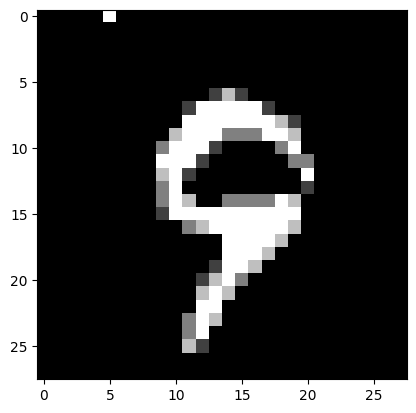

In [65]:
# prediction test & visualization
x,y = next(iter(train_loader))
x,y = x.to(device),y.to(device)
neg_x = model_sigmoid_threshold.construct_supervised_example(x,y,False)
print("Prediction: ", model_sigmoid_threshold.predict(x,device))
print(" Label: ",y)
plt.imshow(neg_x[0].squeeze().cpu(), cmap='gray')
plt.show()

In [66]:
for i in range(len(total_pos_goodnesses_st)):
  for j in range(len(total_pos_goodnesses_st[i])):
    total_pos_goodnesses_st[i][j] = total_pos_goodnesses_st[i][j].cpu().detach()
for i in range(len(total_neg_goodnesses_st)):
  for j in range(len(total_neg_goodnesses_st[i])):
    total_neg_goodnesses_st[i][j] = total_neg_goodnesses_st[i][j].cpu().detach()

In [67]:
for i in range(len(train_losses_st)):
  train_losses_st[i] = train_losses_st[i].cpu().detach()
for i in range(len(test_losses_st)):
  test_losses_st[i] = test_losses_st[i].cpu().detach()
for i in range(len(test_accuracies_st)):
  test_accuracies_st[i] = test_accuracies_st[i].cpu().detach()

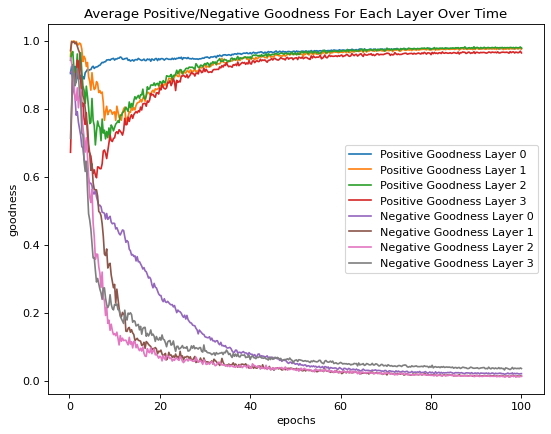

In [68]:
# plot goodness for model trained using sigmoid minus threshold
plot_goodnesses(total_pos_goodnesses_st, total_neg_goodnesses_st, num_epochs, records_per_epoch)

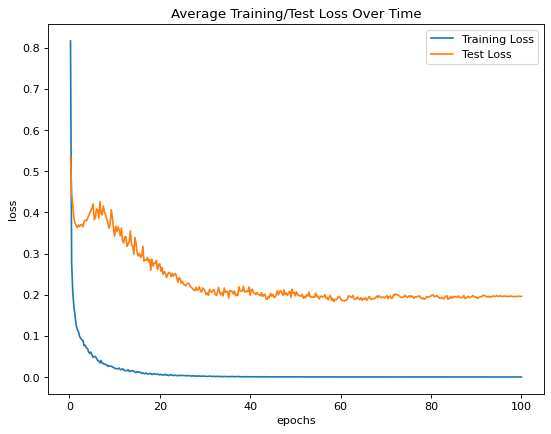

In [69]:
# plot training/test loss for model trained using sigmoid minus threshold
plot_losses(train_losses_st, test_losses_st, num_epochs, records_per_epoch)

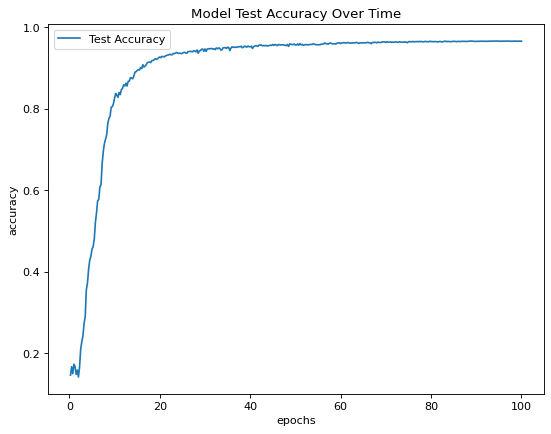

In [70]:
# plot test accuracy for model trained using sigmoid minus threshold
plot_accuracies(test_accuracies_st, num_epochs, records_per_epoch)